This project is mostly based on the Lesson 2 of the *Practical Deep Learning for Coders* course by fastai. I tried it for a new task and obtained Grad-CAM heatmaps for a few examples. The results I got seemed pretty interesting.

##Installations and imports

In [2]:
!pip install fastcore==1.0.9

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
import fastai
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 4.6MB/s 
     |████████████████████████████████| 1.0MB 24.7MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 36.7MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 
     |████████████████████████████████| 40kB 7.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 2.6MB 21.6MB/s 
Mounted at /content/gdrive


##Building our custom dataset

I'm using the  Bing Image Search API v7 to get the pictures for our dataset. To get the pictures for the relevant categories, run the code below. This will give 150 pictures for each category.  You should replace the 'X' below with your API key.  
For getting the API key, refer [https://azure.microsoft.com/en-in/try/cognitive-services/?api=search-api-v7](https://azure.microsoft.com/en-in/try/cognitive-services/?api=search-api-v7).

In [16]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX') #replace XXX with your personal Azure search key

In [102]:
garment_types = '60s bell bottom pants men', 'ripped jeans men'
path = Path("/content/gdrive/My Drive/fastai/garments") #give the appropriate folder structure you are using

In [103]:
if not path.exists():
    path.mkdir()
    for o in garment_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [104]:
fns = get_image_files(path)

Below, we identify and remove any image files that are corrupt

In [105]:
failed = verify_images(fns)
failed

(#0) []

In [106]:
failed.map(Path.unlink);

At this point, head to the folder where the images are stored and manually delete any images that are inappropriate to our search query. This improves the accuracy of the model by a lot.  
Sadly, since Colab does not support the Image Cleaner widget from fastai, we need to do this data cleaning step manually :(

##Building the model

Time to build the model!
I tried training using ResNet 18, 34 and 50. In the end I decided to go with ResNet34.  ResNet 18 was too basic for the task. On the other hand, ResNet 50 gave me poorer performance than ResNet 34. This is because ResNet 50 is a very complex and deep model for our task and will therefore overfit easily.  
 One thing to note is that we are going to train our dataset on a pre-trained ImageNet model. This approach popularized by Jeremy Howard is called Transfer Learning.

In [107]:
garments = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

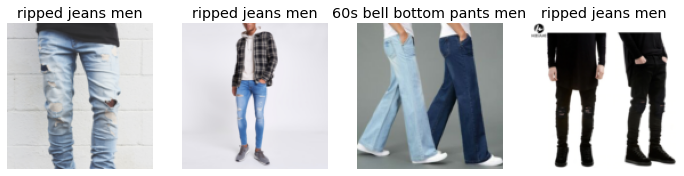

In [108]:
dls = garments.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [109]:
garments = garments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = garments.dataloaders(path)

In [110]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.302255,1.389652,0.425926,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.558746,0.604482,0.296296,00:06
1,0.413955,0.202918,0.055556,00:06
2,0.316829,0.147227,0.018519,00:06
3,0.243948,0.125755,0.018519,00:06


We are getting an error rate of 1.8%. Lets see where the model is making mistakes.  
For this , we plot a Confusion matrix.

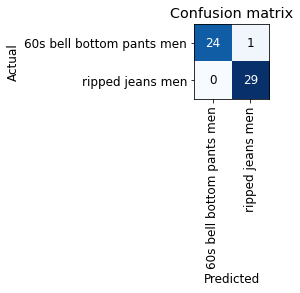

In [111]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The makes one mistake - where it misinterprets a bell bottom pant as a ripped jean.  
Lets take a look at top 5  examples where the model made the most mistakes or was least confident in predicting.

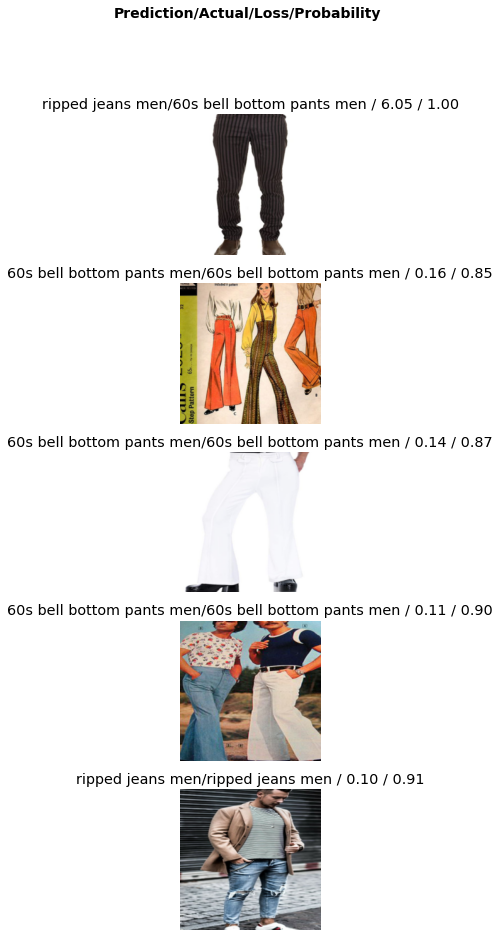

In [112]:
interp.plot_top_losses(5, nrows=5)

As we can see, it predicted the first picture incorrectly. Its evident that the picture is not a truly bell bottom jean. So I'm convinced  that my model didn't make a big mistake over there. As for the other examples, it got them correct  and was also pretty confident in making the prediction. We can say this because the model was 85% confident in making its least confident prediction. 

Time to export our model, so that we don't have to train it again

In [113]:
learn.export(fname = 'garment_project.pkl')
!mv /content/garment_project.pkl /content/gdrive/My\ Drive/fastai/garments #change this to the appropriate folder structure you are using.

##Performing Grad-CAM on our trained model

Lets import our trained model

In [114]:
learn = load_learner(path/'garment_project.pkl')

We will use Grad-CAM heatmaps to visualise the parts of the picture that lead to activations. We do this by getting the weights from the last convolution layer.  
The code for this is credited to [https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb](https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb)  
I made a tweaked it to work for fastai2.

We first get the final convolution layer. For ResNet34, I found it in layer of index [0][7][2]. But this is dependent on the network architecture.

In [115]:
target_layer = learn.model[0][7][2]
target_layer

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Once we have access to the required layer, we use a feature of PyTorch called "hooks" which lets us get the weight values of the layer we are interested in

In [116]:
x = torch.randn(512,512,2,3)
with hook_output(target_layer) as h:
    y = target_layer(x)
    test_eq(y, h.stored)
    assert not h.stored.requires_grad

In [117]:
test_eq

<function fastcore.test.test_eq>

In [118]:
fmap_hook = hook_output(target_layer, detach=True, cpu=False, grad=False)

In [119]:
def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = Hook(target_layer, gradient_torch_hook, is_forward=False)

Once we have the weights,we can use it to see the heatmaps on a specific image batch. You can change the value of i to any other valid value and experiment with different images.

In [317]:
i = 3
image_batch, label_batch = next(iter(dls.train))
image = image_batch[i].reshape(1, 3, 224, 224)
label = label_batch[i].reshape(-1)

In [318]:
learn.model = learn.model.cuda() #loading the model on the GPU
learn.model.eval();

In [319]:
learn.model.zero_grad();
out = learn.model(image)

# we need to set the gradients at the output to ones at the predicted class
# and zero everywere else
onehot = torch.zeros(dls.c)
onehot[torch.argmax(out)] = 1.0

# we then backprop from there
out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)

In [320]:
gradients = next(iter(gradient_hook.stored))
gradients.shape

torch.Size([1, 512, 7, 7])

In [321]:
gradient_linearization = gradients.cpu().numpy().sum((2, 3)).reshape(-1)
fmaps = fmap_hook.stored.cpu().numpy()
print(fmaps.shape)
fmaps = fmaps.reshape(512, 7, 7)

(1, 512, 7, 7)


In [322]:
heatmap = np.maximum(0, np.einsum('i, ijk',gradient_linearization, fmaps))

# we now upsample the heatmap so we can overlay it on our original image
upsampled = scipy.ndimage.zoom(heatmap, 32)
upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))

In [323]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied


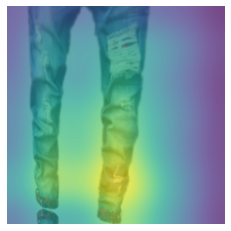

In [324]:
plt.imshow(image_from_tensor(image))
plt.imshow(upsampled, alpha=.7)
plt.gca().set_axis_off()

In [325]:
label

tensor([1], device='cuda:0')

As we can see above, the model focuses on the area above the ankle. This is because the model is trying to find if the bell bottom exists. If not, it will classify it as a ripped jean.  
For the above example, it classified it correctly as a ripped jean even though it never looked for the rip in the first place. Therefore, even any other pant thats not bell bottoms, would be classified as ripped jeans.